In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/MIMIC/mimic_cxr-IV.zip -d /content/train_images_folder

In [ ]:
#!pip install monai

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import tensorflow as tf
import numpy as np
#from monai.networks.nets import DenseNet121
import os
import json
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
from sklearn.metrics import f1_score
import random
import statistics

In [ ]:
'''
train_json_path = "/content/drive/MyDrive/MIMIC/train_data.json"
unique_labels_path = "/content/drive/MyDrive/MIMIC/unique_labels.json"
images_folder = "/content/train_images_folder/re_512_3ch/Train"
output_folder = "/content/Train_dataset"

os.makedirs(output_folder, exist_ok=True)

with open(train_json_path, "r") as f:
    train_data = json.load(f)

with open(unique_labels_path, "r") as f:
    unique_labels = json.load(f)

label_to_index = {label: i for i, label in enumerate(unique_labels)}

dataset = []
for entry in tqdm(train_data, desc="Processing JSON entries"):
    image_id = entry["id"]
    labels = entry["label"].strip("'").split("', '") if entry["label"] else []

    if not labels:
        continue

    label_vector = np.zeros(len(unique_labels), dtype=np.float32)
    for label in labels:
        if label in label_to_index:
          label_vector[label_to_index[label]] = 1

    image_path = os.path.join(images_folder, f"{image_id}.jpg")
    if os.path.exists(image_path):
        with Image.open(image_path) as img:

            img_gray = img.convert("L")

            output_image_path = os.path.join(output_folder, f"{image_id}.jpg")
            img_gray.save(output_image_path)

            dataset.append({"image_path": output_image_path, "label_vector": label_vector.tolist(), "counter": 0})

dataset_json_path = os.path.join(output_folder, "dataset.json")
with open(dataset_json_path, "w") as f:
    json.dump(dataset, f)

print(f"Processed dataset saved at {output_folder}")
'''

'\ntrain_json_path = "/content/drive/MyDrive/MIMIC/train_data.json"\nunique_labels_path = "/content/drive/MyDrive/MIMIC/unique_labels.json"\nimages_folder = "/content/train_images_folder/re_512_3ch/Train"\noutput_folder = "/content/Train_dataset"\n\nos.makedirs(output_folder, exist_ok=True)\n\nwith open(train_json_path, "r") as f:\n    train_data = json.load(f)\n\nwith open(unique_labels_path, "r") as f:\n    unique_labels = json.load(f)\n\nlabel_to_index = {label: i for i, label in enumerate(unique_labels)}\n\ndataset = []\nfor entry in tqdm(train_data, desc="Processing JSON entries"):\n    image_id = entry["id"]\n    labels = entry["label"].strip("\'").split("\', \'") if entry["label"] else []\n\n    if not labels:\n        continue\n\n    label_vector = np.zeros(len(unique_labels), dtype=np.float32)\n    for label in labels:\n        if label in label_to_index:\n          label_vector[label_to_index[label]] = 1\n\n    image_path = os.path.join(images_folder, f"{image_id}.jpg")\n    

In [ ]:
'''
class CustomDataset(Dataset):
  def __init__(self, data_json, transform=None, sample_size=9000, seed=42):
        if sample_size and len(data_json) > sample_size:
            random.seed(seed)
            self.data = random.sample(data_json, sample_size)
        else:
            self.data = data_json

        self.transform = transform

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        img_path = self.data[idx]['image_path']
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.data[idx]['label_vector'], dtype=torch.float16)
        """
        old = new
        float32 = float16
        """
        #counter = torch.tensor(self.data[idx]['counter'], dtype=torch.float32)

        return image, label
'''

'\nclass CustomDataset(Dataset):\n  def __init__(self, data_json, transform=None, sample_size=9000, seed=42):\n        if sample_size and len(data_json) > sample_size:\n            random.seed(seed)\n            self.data = random.sample(data_json, sample_size)\n        else:\n            self.data = data_json\n\n        self.transform = transform\n\n  def __len__(self):\n        return len(self.data)\n\n  def __getitem__(self, idx):\n        img_path = self.data[idx][\'image_path\']\n        image = Image.open(img_path).convert(\'L\')\n        if self.transform:\n            image = self.transform(image)\n        label = torch.tensor(self.data[idx][\'label_vector\'], dtype=torch.float16)\n        """\n        old = new\n        float32 = float16\n        """\n        #counter = torch.tensor(self.data[idx][\'counter\'], dtype=torch.float32)\n\n        return image, label\n'

In [ ]:
'''
with open('/content/Train_dataset/dataset.json', 'r') as f:
  dataset_json = json.load(f)
'''

"\nwith open('/content/Train_dataset/dataset.json', 'r') as f:\n  dataset_json = json.load(f)\n"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  # میانگین کانال‌های RGB
                         (0.5, 0.5, 0.5))  # انحراف معیار کانال‌ها
])

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
#dataset = CustomDataset(dataset_json, transform=transform)
from torch.utils.data import random_split

In [ ]:
train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform)

val_dataset = datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform)


# Get 20% subset
total_size = len(train_dataset)
subset_size = int(0.2 * total_size)  # 20% of 50,000 = 10,000
remaining_size = total_size - subset_size

# Randomly split
train_dataset, _ = random_split(train_dataset, [subset_size, remaining_size])

total_sizee = len(val_dataset)
subset_sizee = int(0.2 * total_sizee)  # 20% of 50,000 = 10,000
remaining_sizee = total_sizee - subset_sizee

# Randomly split
val_dataset, _ = random_split(val_dataset, [subset_sizee, remaining_sizee])

100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s]


In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          shuffle=False,
                          num_workers=2)

val_loader = DataLoader(val_dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=2)

In [ ]:
import torch
import torch.nn as nn
from timm.models import create_model
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

class TinyViTClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyViTClassifier, self).__init__()
        # Load a pretrained Tiny ViT model from timm
        self.vit = create_model(
            'vit_tiny_patch16_224',  # Tiny ViT with patch size 16
            pretrained=True,
            num_classes=num_classes
        )

        # Add a channel expansion layer for grayscale inputs
        #self.expand_channels = nn.Conv2d(1, 3, kernel_size=1)

    def forward(self, x):
        # Expand grayscale input to 3 channels
        #x = self.expand_channels(x)
        #x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # Forward pass through the Vision Transformer
        x = self.vit(x)
        return x

In [ ]:
class TinyViTevaluation(nn.Module):
    def __init__(self, num_classes=3):
        super(TinyViTevaluation, self).__init__()
        # Load a pretrained Tiny ViT model from timm
        self.vit = create_model(
            'vit_tiny_patch16_224',  # Tiny ViT with patch size 16
            pretrained=True,
            num_classes=10
        )

        # Add a channel expansion layer for grayscale inputs
        #self.expand_channels = nn.Conv2d(1, 3, kernel_size=1)

    def forward(self, x):
        # Expand grayscale input to 3 channels
        #x = self.expand_channels(x)
        #x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # Forward pass through the Vision Transformer
        x = self.vit(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_val = TinyViTevaluation(num_classes=3).to(device) ########### change
model_class = TinyViTClassifier(num_classes=10).to(device)

val_optimizer = torch.optim.Adam(model_val.parameters(), lr=0.001) #weight_decay = 1e-2
model_optimizer = torch.optim.Adam(model_class.parameters(), lr=0.00001)

criterion = nn.CrossEntropyLoss()
criterion_E = nn.CrossEntropyLoss()  # Agent(evaluation)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import Subset
import random

In [ ]:
'''
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, test_size])
'''

'\nfrom torch.utils.data import random_split\n\ntrain_size = int(0.8 * len(dataset))\ntest_size = len(dataset) - train_size\n\ntrain_dataset, val_dataset = random_split(dataset, [train_size, test_size])\n'

In [ ]:
print(len(train_dataset), len(val_dataset))

10000 2000


In [ ]:
'''
from torch.utils.data import Subset
import random

# شافل کردن اندیس‌ها
indices1 = list(range(len(train_dataset)))
random.seed(42)  # برای reproducibility
random.shuffle(indices1)


# شافل کردن اندیس‌ها
indices2 = list(range(len(val_dataset)))
random.seed(42)  # برای reproducibility
random.shuffle(indices2)

# ساختن دیتاست شافل‌شده
train_dataset = Subset(train_dataset, indices1)
val_dataset = Subset(val_dataset, indices2)
'''

'\nfrom torch.utils.data import Subset\nimport random\n\n# شافل کردن اندیس\u200cها\nindices1 = list(range(len(train_dataset)))\nrandom.seed(42)  # برای reproducibility\nrandom.shuffle(indices1)\n\n\n# شافل کردن اندیس\u200cها\nindices2 = list(range(len(val_dataset)))\nrandom.seed(42)  # برای reproducibility\nrandom.shuffle(indices2)\n\n# ساختن دیتاست شافل\u200cشده\ntrain_dataset = Subset(train_dataset, indices1)\nval_dataset = Subset(val_dataset, indices2)\n'

In [ ]:
#print(len(train_dataset), len(val_dataset))

In [ ]:
batch_size = 100
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
criterion1 = nn.CrossEntropyLoss(reduction='none')

In [ ]:
import torch.nn.functional as F
from collections import Counter
from sklearn.mixture import GaussianMixture
import numpy as np

epochs = 10

# DataLoader بدون shuffle برای حفظ ترتیب تصاویر


for epoch in range(epochs):
    print("=" * 80)
    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 80)

    # ----------- مرحله اول: آموزش مدل ۱۴ کلاسه و استخراج loss ----------- #
    model_class.train()
    loss_list = []

    total_loss_class = 0
    total_samples = 0

    # برای داده‌های train
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_class(images)
        loss = criterion(outputs, labels)

        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()

        total_loss_class += loss.item() * images.size(0)
        total_samples += images.size(0)

        # ذخیره‌ی loss برای هر تصویر
        with torch.no_grad():###########
            preds = model_class(images)
            per_sample_loss = criterion1(preds, labels)
            #print(per_sample_loss.size())
            loss_per_image = per_sample_loss.cpu().numpy().tolist()
            loss_list.extend(loss_per_image)

    avg_loss_class_train = total_loss_class / total_samples


    # ----------- مرحله دوم: خوشه‌بندی GMM روی lossها ----------- #
    loss_array = np.array(loss_list).reshape(-1, 1)
    #loss_array = np.array(loss_list)
    gmm = GaussianMixture(n_components=3, random_state=42).fit(loss_array)
    cluster_ids = gmm.predict(loss_array)

    means = gmm.means_.flatten()
    sorted_clusters = np.argsort(means)
    cluster_to_difficulty = {sorted_clusters[0]: 0, sorted_clusters[1]: 1, sorted_clusters[2]: 2}
    difficulty_labels = [cluster_to_difficulty[c] for c in cluster_ids]

    # گزارش آماری خوشه‌ها
    counter = Counter(difficulty_labels)



    difficulty_labels_tensor = torch.tensor(difficulty_labels, dtype=torch.long).to(device)

    # ----------- مرحله سوم: آموزش مدل ارزش‌گذاری (۳ کلاس) ----------- #
    model_val.train()
    total_loss_val = 0
    idx = 0

    # برای داده‌های train
    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_loss_val_train = total_loss_val / len(difficulty_labels)

    # ----------- مرحله چهارم: ارزیابی مدل‌ها روی داده‌های validation ----------- #
    """
    # مدل کلاسفیکیشن روی داده‌های validation
    model_class.eval()
    total_loss_class_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_class(images)
            loss = criterion(outputs, labels)

            total_loss_class_val += loss.item() * images.size(0)
            total_samples_val += images.size(0)
    """
    #avg_loss_class_val = total_loss_class_val / total_samples_val
    print(f"Average classification loss (14-class model) on train: {avg_loss_class_train:.4f}")
    #print(f"Average classification loss (14-class model) on validation: {avg_loss_class_val:.4f}")


    print("\nClustering losses with GMM...")
    print("\nCluster distribution:")
    for d in [0, 1, 2]:
        count = counter[d]
        percent = 100 * count / len(difficulty_labels)
        print(f"  Difficulty {d} → {count} samples ({percent:.2f}%)")
    """
    # مدل ارزش‌گذاری روی داده‌های validation
    model_val.eval()
    total_loss_val_eval = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_loss_val_eval += loss_val.item() * images.size(0)
    """
    #avg_loss_val_eval = total_loss_val_eval / len(difficulty_labels)
    print(f"\nAverage Evaluation loss (3-class model) on train: {avg_loss_val_train:.4f}")
    #print(f"Average Evaluation loss (3-class model) on validation: {avg_loss_val_eval:.4f}")

    print("=" * 80 + "\n")



final_epochs = 8
for final_epoch in range(final_epochs):
    print(f"\nFinal Epoch {final_epoch + 1}/{final_epochs}")
    model_val.train()
    total_loss_val = 0
    idx = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_final_train_loss = total_loss_val / len(difficulty_labels)
    """
    # ارزیابی روی validation
    model_val.eval()
    total_val_loss = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_val_loss += loss_val.item() * images.size(0)
    """
    #avg_final_val_loss = total_val_loss / len(difficulty_labels)

    print(f"Train Loss: {avg_final_train_loss:.4f}")

Epoch 1/10
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 1.0332

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 4305 samples (43.05%)
  Difficulty 1 → 3917 samples (39.17%)
  Difficulty 2 → 1778 samples (17.78%)

Average Evaluation loss (3-class model) on train: 0.8982

Epoch 2/10
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 0.2692

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 5499 samples (54.99%)
  Difficulty 1 → 3221 samples (32.21%)
  Difficulty 2 → 1280 samples (12.80%)

Average Evaluation loss (3-class model) on train: 0.9622

Epoch 3/10
--------------------------------------------------------------------------------
Average classification loss (14-class model) on train: 0.1463

Clustering losses with GMM...

Cluster distribution:
  Difficulty 0 → 6172 sa

In [ ]:
val_optimizer = torch.optim.Adam(model_val.parameters(), lr=0.0001) #weight_decay = 1e-2

In [ ]:
final_epochs = 5
for final_epoch in range(final_epochs):
    print(f"\nFinal Epoch {final_epoch + 1}/{final_epochs}")
    model_val.train()
    total_loss_val = 0
    idx = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_final_train_loss = total_loss_val / len(difficulty_labels)
    """
    # ارزیابی روی validation
    model_val.eval()
    total_val_loss = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_val_loss += loss_val.item() * images.size(0)
    """
    #avg_final_val_loss = total_val_loss / len(difficulty_labels)

    print(f"Train Loss: {avg_final_train_loss:.4f}")


Final Epoch 1/5
Train Loss: 0.5617

Final Epoch 2/5
Train Loss: 0.5580

Final Epoch 3/5
Train Loss: 0.5553

Final Epoch 4/5
Train Loss: 0.5509

Final Epoch 5/5
Train Loss: 0.5468


In [ ]:
# Save Models
torch.save(model_class.state_dict(), '/content/drive/MyDrive/CIFAR/models/model_classifier.pth')
torch.save(model_val.state_dict(), '/content/drive/MyDrive/CIFAR/models/model_evaluation.pth')

In [ ]:
features_list = []
labels_list = []

model_val.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        #images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images)
        preds = model_val(images).argmax(dim=1)

        features_list.append(feats.cpu())
        labels_list.append(preds.cpu())

features_tensor = torch.cat(features_list, dim=0).numpy()
labels_tensor = torch.cat(labels_list, dim=0).numpy()

In [ ]:
print(features_tensor[:, 0, :].shape)
print(len(labels_tensor))

(10000, 192)
10000


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(features_tensor[:, 0, :], labels_tensor)
dbi_score = davies_bouldin_score(features_tensor[:, 0, :], labels_tensor)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Silhouette Score: 0.6008
Davies-Bouldin Index: 0.6844


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d = tsne.fit_transform(features_tensor[:, 0, :])

<ipython-input-32-e4e0d16de234>:23: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))


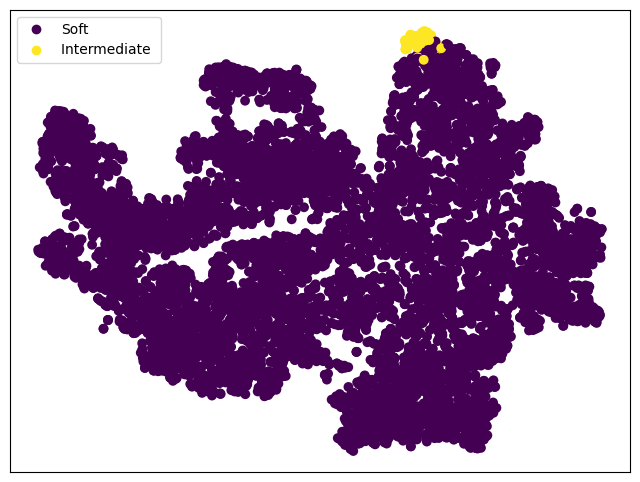

In [ ]:
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d[:, 0],
    feats_2d[:, 1],
    c=labels_tensor,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d = tsne.fit_transform(features_tensor[:, 0, :])  # یا features_flattened

<ipython-input-36-ec6c064b3ea2>:23: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))


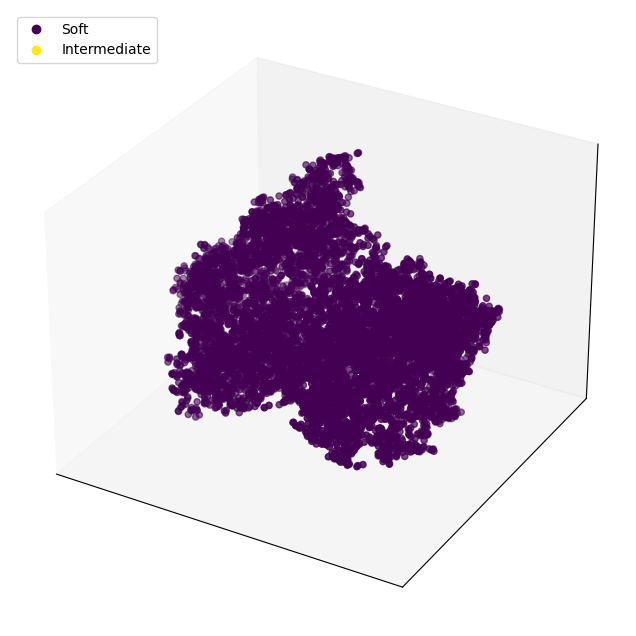

In [ ]:
# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d[:, 0],
    feats_3d[:, 1],
    feats_3d[:, 2],
    c=labels_tensor,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()

In [ ]:
features_list1 = []
labels_list1 = []

model_val.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)

        #images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images)
        preds = model_val(images).argmax(dim=1)

        features_list1.append(feats.cpu())
        labels_list1.append(preds.cpu())

features_tensor1 = torch.cat(features_list1, dim=0).numpy()
labels_tensor1 = torch.cat(labels_list1, dim=0).numpy()
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")

Silhouette Score: 0.5799
Davies-Bouldin Index: 0.6130


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d1 = tsne.fit_transform(features_tensor1[:, 0, :])

<ipython-input-41-b44a530252a1>:23: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))


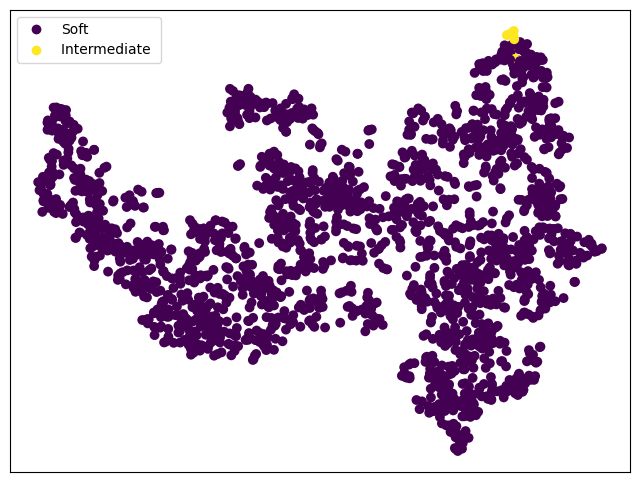

In [ ]:
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d1[:, 0],
    feats_2d1[:, 1],
    c=labels_tensor1,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()

In [ ]:
# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d1 = tsne.fit_transform(features_tensor1[:, 0, :])  # یا features_flattened

<ipython-input-43-723b761a93c8>:25: UserWarning: Mismatched number of handles and labels: len(handles) = 2 len(labels) = 3
  ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))


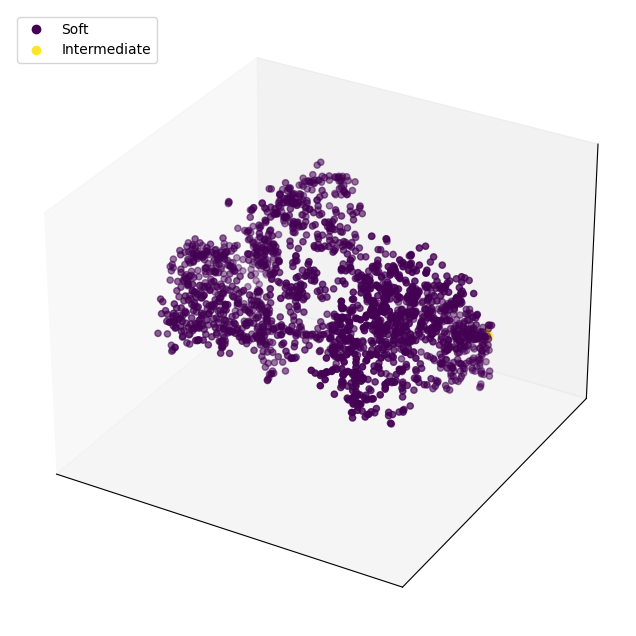

In [ ]:
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d1[:, 0],
    feats_3d1[:, 1],
    feats_3d1[:, 2],
    c=labels_tensor1,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()

In [ ]:
"""
final_epochs = 10
for final_epoch in range(final_epochs):
    print(f"\nFinal Epoch {final_epoch + 1}/{final_epochs}")
    model_val.train()
    total_loss_val = 0
    idx = 0

    for images, _ in train_loader:
        images = images.to(device)
        batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
        idx += images.size(0)

        outputs = model_val(images)
        loss_val = criterion_E(outputs, batch_labels)

        val_optimizer.zero_grad()
        loss_val.backward()
        val_optimizer.step()

        total_loss_val += loss_val.item() * images.size(0)

    avg_final_train_loss = total_loss_val / len(difficulty_labels)

    # ارزیابی روی validation
    model_val.eval()
    total_val_loss = 0
    idx = 0

    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            batch_labels = difficulty_labels_tensor[idx:idx + images.size(0)]
            idx += images.size(0)

            outputs = model_val(images)
            loss_val = criterion_E(outputs, batch_labels)

            total_val_loss += loss_val.item() * images.size(0)

    avg_final_val_loss = total_val_loss / len(difficulty_labels)

    print(f"Train Loss: {avg_final_train_loss:.4f} | Validation Loss: {avg_final_val_loss:.4f}")
torch.save(model_val.state_dict(), '/content/drive/MyDrive/MIMIC/Class_model_eval_img/model_evaluation1.pth')
"""


Final Epoch 1/10
Train Loss: 0.2516 | Validation Loss: 0.5409

Final Epoch 2/10
Train Loss: 0.2156 | Validation Loss: 0.4944

Final Epoch 3/10
Train Loss: 0.1970 | Validation Loss: 0.5433

Final Epoch 4/10
Train Loss: 0.2077 | Validation Loss: 0.5220

Final Epoch 5/10
Train Loss: 0.2144 | Validation Loss: 0.5786

Final Epoch 6/10
Train Loss: 0.2561 | Validation Loss: 0.5433

Final Epoch 7/10
Train Loss: 0.1524 | Validation Loss: 0.6434

Final Epoch 8/10
Train Loss: 0.1337 | Validation Loss: 0.5222

Final Epoch 9/10
Train Loss: 0.1331 | Validation Loss: 0.5588

Final Epoch 10/10
Train Loss: 0.1153 | Validation Loss: 0.5965


In [ ]:
"""
features_list = []
labels_list = []

model_val.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list.append(feats.cpu())
        labels_list.append(preds.cpu())

features_tensor = torch.cat(features_list, dim=0).numpy()
labels_tensor = torch.cat(labels_list, dim=0).numpy()
"""

In [ ]:
"""
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(features_tensor[:, 0, :], labels_tensor)
dbi_score = davies_bouldin_score(features_tensor[:, 0, :], labels_tensor)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {dbi_score:.4f}")
"""

Silhouette Score: 0.4017
Davies-Bouldin Index: 1.1391


In [ ]:
"""
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
feats_2d = tsne.fit_transform(features_tensor[:, 0, :])
"""

In [ ]:
"""
import matplotlib.pyplot as plt

# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d[:, 0],
    feats_2d[:, 1],
    c=labels_tensor,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()
"""

In [ ]:
"""
# اجرای t-SNE با ۳ مولفه
tsne = TSNE(n_components=3, random_state=42)
feats_3d = tsne.fit_transform(features_tensor[:, 0, :])  # یا features_flattened
"""

In [ ]:
"""
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d[:, 0],
    feats_3d[:, 1],
    feats_3d[:, 2],
    c=labels_tensor,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()
"""

In [ ]:
"""
features_list1 = []
labels_list1 = []

model_val.eval()
with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)

        images_rgb = model_val.expand_channels(images)  # تبدیل به ۳ کانال
        feats = model_val.vit.forward_features(images_rgb)
        preds = model_val(images).argmax(dim=1)

        features_list1.append(feats.cpu())
        labels_list1.append(preds.cpu())

features_tensor1 = torch.cat(features_list1, dim=0).numpy()
labels_tensor1 = torch.cat(labels_list1, dim=0).numpy()
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")
"""

Silhouette Score: 0.2802
Davies-Bouldin Index: 1.5196


In [ ]:
"""
from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score1 = silhouette_score(features_tensor1[:, 0, :], labels_tensor1)
dbi_score1 = davies_bouldin_score(features_tensor1[:, 0, :], labels_tensor1)

print(f"Silhouette Score: {sil_score1:.4f}")
print(f"Davies-Bouldin Index: {dbi_score1:.4f}")
"""

Silhouette Score: 0.2802
Davies-Bouldin Index: 1.5196


In [ ]:
"""
tsne = TSNE(n_components=2)
feats_2d1 = tsne.fit_transform(features_tensor1[:, 0, :])
"""

In [ ]:
"""
# رسم نمودار
plt.figure(figsize=(8, 6))  # تنظیم اندازه نمودار
scatter = plt.scatter(
    feats_2d1[:, 0],
    feats_2d1[:, 1],
    c=labels_tensor1,
    cmap='viridis',      # پالت رنگی
    s=50,                # اندازه نقاط
    edgecolor='none'     # حذف لبه نقاط
)

# حذف اعداد محورها
plt.xticks([])  # حذف اعداد محور x
plt.yticks([])  # حذف اعداد محور y

# افزودن لجند
unique_label = ['Soft', 'Intermediate ', 'Hard']
# فرض بر این است که labels_tensor شامل اعداد صحیح (0, 1, 2, ...) است که هر عدد نماینده یک کلاس است.
unique_labels = sorted(set(labels_tensor))  # کلاس‌های منحصر به فرد
legend_labels = [f"{label}" for label in unique_label]  # برچسب‌های متنی برای هر کلاس
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# حذف خطوط دور نمودار (اختیاری)
#ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

# افزودن عنوان و برچسب‌ها (اختیاری)
#plt.title("t-SNE Visualization", fontsize=14, pad=20)
#plt.colorbar(label='Classes')  # نمایش نوار رنگی برای برچسب‌ها

plt.show()
"""

In [ ]:
"""
tsne = TSNE(n_components=3, random_state=42)
feats_3d1 = tsne.fit_transform(features_tensor1[:, 0, :])  # یا features_flattened
from matplotlib import pyplot as plt

# ایجاد شکل و محور سه‌بعدی
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# رسم نمودار سه‌بعدی
scatter = ax.scatter(
    feats_3d1[:, 0],
    feats_3d1[:, 1],
    feats_3d1[:, 2],
    c=labels_tensor1,
    cmap='viridis',
    s=20
)

# حذف اعداد محورها
ax.set_xticks([])  # حذف اعداد محور x
ax.set_yticks([])  # حذف اعداد محور y
ax.set_zticks([])  # حذف اعداد محور z

# افزودن لجند
unique_labels = ['Soft', 'Intermediate', 'Hard']  # نام‌های کلاس‌ها
legend_elements = scatter.legend_elements()[0]  # عناصر گرافیکی برای لجند
ax.legend(handles=legend_elements, labels=unique_labels, loc='upper left', bbox_to_anchor=(0.0, 1))

# نمایش نمودار
plt.show()
"""

In [ ]:
model_path = "/content/drive/MyDrive/CIFAR/models/model_evaluation.pth"
model_val = TinyViTevaluation(num_classes=3).to(device)
checkpoint = torch.load(model_path, map_location=torch.device('cuda'))
model_val.load_state_dict(checkpoint)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CIFAR/models/model_evaluation.pth'

In [ ]:
#!rm -rf /content/drive/MyDrive/MIMIC2/data/*

In [ ]:
import os
import csv
from torchvision.utils import save_image
from torch.utils.data import random_split

# مسیر ذخیره‌سازی تصاویر
output_base_dir = "/content/drive/MyDrive/CIFAR/data"
os.makedirs(output_base_dir, exist_ok=True)
for i in range(3):
    os.makedirs(os.path.join(output_base_dir, f"class_{i}"), exist_ok=True)

# فایل CSV برای ذخیره مسیر تصاویر و برچسب‌ها
csv_path = os.path.join(output_base_dir, "labels.csv")
csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["filepath", "label"])  # عنوان ستون‌ها

# غیرفعال کردن گرادیان برای inference
model_val.eval()
with torch.no_grad():
    img_idx = 0  # شمارنده برای نام‌گذاری تصاویر

    for images, labels in train_loader:
        images = images.to(device)

        outputs = model_val(images)
        predicted_labels = torch.argmax(outputs, dim=1)  # گرفتن برچسب 0, 1, 2

        for i in range(images.size(0)):
            label = predicted_labels[i].item()
            class_dir = os.path.join(output_base_dir, f"class_{label}")
            img_filename = f"img_{img_idx}.png"
            save_path = os.path.join(class_dir, img_filename)

            save_image(images[i], save_path)
            csv_writer.writerow([save_path, labels[i]])
            img_idx += 1

csv_file.close()
print("ذخیره‌سازی تصاویر و برچسب‌ها تمام شد.")

ذخیره‌سازی تصاویر و برچسب‌ها تمام شد.


In [ ]:
#!rm -rf /content/drive/MyDrive/MIMIC/subset_data/*

In [ ]:
'''
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])

        image = Image.open(img_path).convert("L")  # چون grayscale هست

        if self.transform:
            image = self.transform(image)

        return image, label
'''

In [ ]:
'''
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

csv_path = "/content/drive/MyDrive/MIMIC/Class_model_eval/labels.csv"
dataset = CustomImageDataset(csv_file=csv_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
'''

In [ ]:
'''
import os
import random
import shutil
from sklearn.model_selection import train_test_split

input_dirs = {
    '0': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_0',
    '1': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_1',
    '2': '/content/drive/MyDrive/MIMIC/Class_model_eval/class_2',
}
subset_root = '/content/drive/MyDrive/MIMIC/subset'
os.makedirs(subset_root, exist_ok=True)

for class_label, dir_path in input_dirs.items():
    all_files = os.listdir(dir_path)
    sampled_files = random.sample(all_files, int(0.2 * len(all_files)))
    target_dir = os.path.join(subset_root, class_label)
    os.makedirs(target_dir, exist_ok=True)

    for file in sampled_files:
        src = os.path.join(dir_path, file)
        dst = os.path.join(target_dir, file)
        shutil.copy(src, dst)
'''

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/CIFAR/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/CIFAR/data/class_0',
    '1': '/content/drive/MyDrive/CIFAR/data/class_1',
    '2': '/content/drive/MyDrive/CIFAR/data/class_2',
}

subset_root = '/content/drive/MyDrive/CIFAR/subset'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.9 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("90% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

90% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
#folder_path = '/content/drive/MyDrive/CIFAR/subset'
#file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

In [ ]:
#!rm -rf /content/drive/MyDrive/CIFAR/subset/*

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')  # بارگذاری تصویر

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
############ subset learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
csv_path = '/content/drive/MyDrive/CIFAR/subset/subset_labels.csv'
dataset = CustomDataset(csv_file=csv_path, transform=transform)
train_loader1 = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
model1 = TinyViTClassifier(num_classes=10).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.0001)
criterion1 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# تقسیم مجموعه داده
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader1 = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader1 = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [ ]:
'''
import ast
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def process_labels(labels):
    labels = list(labels)
    for i in range(len(labels)):
        clean_str = labels[i].replace('\\n', '').strip()
        labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)
    return torch.stack(labels)

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = process_labels(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            total_loss += loss.item()
            probs = torch.sigmoid(outputs)
            preds = (probs >= threshold).float()
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc = "N/A (check if all classes are present)"

    return total_loss, acc, f1_macro, f1_micro, auc

# حلقه آموزش
for epoch in range(30):
    model1.train()
    total_loss = 0.0
    for inputs, labels in train_loader1:
        labels = process_labels(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    # ارزیابی بر روی داده‌های آموزش
    _, train_acc, train_f1macro, train_f1micro, train_auc = evaluate_model(model1, train_loader1, dataset_name='train')

    # ارزیابی بر روی داده‌های اعتبارسنجی
    val_loss, val_acc, val_f1macro, val_f1micro, val_auc = evaluate_model(model1, val_loader, dataset_name='val')

    print(f"Epoch {epoch+1}/30")
    print(f"Train - Loss: {total_loss:.4f}, Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro:.4f}, AUC: {train_auc}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1_macro: {val_f1macro:.4f}, F1_micro: {val_f1micro:.4f}, AUC: {val_auc}")
    '''

'\nimport ast\nimport torch\nimport torch.nn.functional as F\nfrom sklearn.metrics import accuracy_score, f1_score, roc_auc_score\n\ndef process_labels(labels):\n    labels = list(labels)\n    for i in range(len(labels)):\n        clean_str = labels[i].replace(\'\\n\', \'\').strip()\n        labels[i] = torch.tensor(ast.literal_eval(clean_str[9:-30].strip()), dtype=torch.float32)\n    return torch.stack(labels)\n\ndef evaluate_model(model, loader, dataset_name=None, threshold=0.5):\n    model.eval()\n    all_labels = []\n    all_preds = []\n    all_probs = []\n    total_loss = 0.0\n\n    with torch.no_grad():\n        for inputs, labels in loader:\n            labels = process_labels(labels)\n            inputs = inputs.to(device)\n            labels = labels.to(device)\n            outputs = model(inputs)\n            loss = criterion1(outputs, labels)\n            total_loss += loss.item()\n            probs = torch.sigmoid(outputs)\n            preds = (probs >= threshold).float()\n

In [ ]:
import ast
import re
for epoch in range(20):
    #print(epoch)
    model1.train()
    total_loss = 0
    for inputs, labels in train_loader1:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 29.8807
Epoch 2/30 - Loss: 12.5613
Epoch 3/30 - Loss: 5.4003
Epoch 4/30 - Loss: 2.1255
Epoch 5/30 - Loss: 2.6184
Epoch 6/30 - Loss: 4.1916
Epoch 7/30 - Loss: 3.7958
Epoch 8/30 - Loss: 3.2199
Epoch 9/30 - Loss: 2.7587
Epoch 10/30 - Loss: 2.2782
Epoch 11/30 - Loss: 1.7839
Epoch 12/30 - Loss: 1.2401
Epoch 13/30 - Loss: 1.3708
Epoch 14/30 - Loss: 1.2251
Epoch 15/30 - Loss: 2.2960
Epoch 16/30 - Loss: 3.8507
Epoch 17/30 - Loss: 3.0151
Epoch 18/30 - Loss: 1.1782
Epoch 19/30 - Loss: 0.6561
Epoch 20/30 - Loss: 0.5995


In [ ]:
import ast
import re
for epoch in range(10):
    #print(epoch)
    model1.train()
    total_loss = 0
    for inputs, labels in train_loader1:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer1.zero_grad()
        outputs = model1(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 0.7873
Epoch 2/30 - Loss: 0.1239
Epoch 3/30 - Loss: 0.0404
Epoch 4/30 - Loss: 0.0214
Epoch 5/30 - Loss: 0.0179
Epoch 6/30 - Loss: 0.0157
Epoch 7/30 - Loss: 0.0141
Epoch 8/30 - Loss: 0.0128
Epoch 9/30 - Loss: 0.0118
Epoch 10/30 - Loss: 0.0109


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)

            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion1(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model1, train_loader1, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model1, val_loader1, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.8533, F1: 0.8501, F1_micro: 0.8533333333333334, AUC_macro: NAN, AUC_micro: NAN


In [ ]:
###### Total Data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/CIFAR/data/labels.csv'
dataset2 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader2 = DataLoader(dataset2, batch_size=128, shuffle=True)

In [ ]:
model2 = TinyViTClassifier(num_classes=10).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.0001)
criterion2 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
train_size2 = int(0.8 * len(dataset2))
test_size2 = len(dataset2) - train_size2

# تقسیم مجموعه داده
train_dataset2, test_dataset2 = random_split(dataset2, [train_size2, test_size2])
train_loader2 = DataLoader(train_dataset2, batch_size=100, shuffle=True)
val_loader2 = DataLoader(test_dataset2, batch_size=100, shuffle=True)

In [ ]:
print(len(train_dataset2), len(test_dataset2))

8000 2000


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re
for epoch in range(30):
    model2.train()
    total_loss = 0
    for inputs, labels in train_loader2:
      labels = list(labels)
      for i in range(len(labels)):
        labels[i] = torch.tensor(int(labels[i].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
      labels = torch.stack(labels)
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer2.zero_grad()
      outputs = model2(inputs)
      loss = criterion2(outputs, labels)
      loss.backward()
      optimizer2.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 31.3653
Epoch 2/30 - Loss: 14.0138
Epoch 3/30 - Loss: 6.0521
Epoch 4/30 - Loss: 3.0831
Epoch 5/30 - Loss: 1.4201
Epoch 6/30 - Loss: 6.8587
Epoch 7/30 - Loss: 6.2577
Epoch 8/30 - Loss: 3.2282
Epoch 9/30 - Loss: 2.2503
Epoch 10/30 - Loss: 2.0375
Epoch 11/30 - Loss: 1.0435
Epoch 12/30 - Loss: 1.4830
Epoch 13/30 - Loss: 4.7337
Epoch 14/30 - Loss: 3.1174
Epoch 15/30 - Loss: 2.2666
Epoch 16/30 - Loss: 1.3878
Epoch 17/30 - Loss: 2.1375
Epoch 18/30 - Loss: 1.8375
Epoch 19/30 - Loss: 2.9291
Epoch 20/30 - Loss: 1.1228
Epoch 21/30 - Loss: 0.5078
Epoch 22/30 - Loss: 0.6392
Epoch 23/30 - Loss: 0.6727
Epoch 24/30 - Loss: 1.9205
Epoch 25/30 - Loss: 1.9793
Epoch 26/30 - Loss: 1.3766
Epoch 27/30 - Loss: 0.6513
Epoch 28/30 - Loss: 0.4550
Epoch 29/30 - Loss: 0.3110
Epoch 30/30 - Loss: 0.3840


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              labels[i] = torch.tensor(int(labels[i].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)

            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro


_, train_acc1, train_f1macro1, train_f1micro1, train_auc_ma1, train_auc_mi1 = evaluate_model(model2, train_loader2, dataset_name='train')
print(f"Train - Acc: {train_acc1:.4f}, F1_macro: {train_f1macro1:.4f}, F1_micro: {train_f1micro1}, AUC_macro: {train_auc_ma1}, AUC_micro: {train_auc_mi1}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc1, val_f1macro1, val_f1micro1, val_auc_macro1, val_auc_micro1 = evaluate_model(model2, val_loader2, dataset_name='val')
print(f"Validation - Acc: {val_acc1:.4f}, F1: {val_f1macro1:.4f}, F1_micro: {val_f1micro1}, AUC_macro: {val_auc_macro1}, AUC_micro: {val_auc_micro1}")

Train - Acc: 0.9996, F1_macro: 0.9996, F1_micro: 0.999625, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.8370, F1: 0.8363, F1_micro: 0.837, AUC_macro: NAN, AUC_micro: NAN


# 80%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/CIFAR/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/CIFAR/data/class_0',
    '1': '/content/drive/MyDrive/CIFAR/data/class_1',
    '2': '/content/drive/MyDrive/CIFAR/data/class_2',
}

subset_root = '/content/drive/MyDrive/CIFAR/subset80'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.8 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("80% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

80% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset80 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/CIFAR/subset80/subset_labels.csv'
dataset3 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader3 = DataLoader(dataset3, batch_size=256, shuffle=True)

In [ ]:
model3 = TinyViTClassifier(num_classes=10).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.0001)
criterion3 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset3))
test_size = len(dataset3) - train_size

# تقسیم مجموعه داده
train_dataset3, test_dataset3 = random_split(dataset3, [train_size, test_size])
train_loader3 = DataLoader(train_dataset3, batch_size=100, shuffle=True)
val_loader3 = DataLoader(test_dataset3, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model3.train()
    total_loss = 0
    for inputs, labels in train_loader3:
        #print('1')
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer3.zero_grad()
        outputs = model3(inputs)
        loss = criterion3(outputs, labels)
        loss.backward()
        optimizer3.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 32.9468
Epoch 2/30 - Loss: 14.7910
Epoch 3/30 - Loss: 7.0575
Epoch 4/30 - Loss: 2.7601
Epoch 5/30 - Loss: 1.2696
Epoch 6/30 - Loss: 0.9278
Epoch 7/30 - Loss: 0.3768
Epoch 8/30 - Loss: 0.2744
Epoch 9/30 - Loss: 0.1768
Epoch 10/30 - Loss: 0.1008
Epoch 11/30 - Loss: 0.0781
Epoch 12/30 - Loss: 0.0646
Epoch 13/30 - Loss: 0.0555
Epoch 14/30 - Loss: 0.0512
Epoch 15/30 - Loss: 0.0405
Epoch 16/30 - Loss: 0.0358
Epoch 17/30 - Loss: 0.0228
Epoch 18/30 - Loss: 0.0196
Epoch 19/30 - Loss: 0.0173
Epoch 20/30 - Loss: 0.0157
Epoch 21/30 - Loss: 0.0144


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)

            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion3(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro
# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model3, train_loader3, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model3, val_loader3, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.8494, F1: 0.8488, F1_micro: 0.849375, AUC_macro: NAN, AUC_micro: NAN


# 70%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/CIFAR/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/CIFAR/data/class_0',
    '1': '/content/drive/MyDrive/CIFAR/data/class_1',
    '2': '/content/drive/MyDrive/CIFAR/data/class_2',
}

subset_root = '/content/drive/MyDrive/CIFAR/subset70'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.7 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("70% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

70% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset70 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/CIFAR/subset70/subset_labels.csv'
dataset4 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader4 = DataLoader(dataset4, batch_size=256, shuffle=True)

In [ ]:
model4 = TinyViTClassifier(num_classes=10).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=0.0001)
criterion4 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset4))
test_size = len(dataset4) - train_size

# تقسیم مجموعه داده
train_dataset4, test_dataset4 = random_split(dataset4, [train_size, test_size])
train_loader4 = DataLoader(train_dataset4, batch_size=64, shuffle=True)
val_loader4 = DataLoader(test_dataset4, batch_size=64, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model4.train()
    total_loss = 0
    for inputs, labels in train_loader4:
      print(epoch)
      labels = list(labels)
      for i in range(len(labels)):
        #حالا تبدیل به لیست پایتون و سپس tensor
        labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
      labels = torch.stack(labels)
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer4.zero_grad()
      outputs = model4(inputs)
      loss = criterion4(outputs, labels)
      loss.backward()
      optimizer4.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Epoch 1/30 - Loss: 59.6609
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Epoch 2/30 - Loss: 26.6528
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
Epoch 3/30 - Loss: 11.3951
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
Epoch 4/30 - Loss: 5.6444
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
Epoch 5/30 - 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              #حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)

            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion4(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model4, train_loader4, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model4, val_loader4, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.8293, F1: 0.8291, F1_micro: 0.8292857142857143, AUC_macro: NAN, AUC_micro: NAN


# 60%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/CIFAR/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/CIFAR/data/class_0',
    '1': '/content/drive/MyDrive/CIFAR/data/class_1',
    '2': '/content/drive/MyDrive/CIFAR/data/class_2',
}

subset_root = '/content/drive/MyDrive/CIFAR/subset60'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.6 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("60% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

60% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset60 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/CIFAR/subset60/subset_labels.csv'
dataset5 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader5 = DataLoader(dataset5, batch_size=256, shuffle=True)

In [ ]:
model5 = TinyViTClassifier(num_classes=10).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=0.0001)
criterion5 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset5))
test_size = len(dataset5) - train_size

# تقسیم مجموعه داده
train_dataset5, test_dataset5 = random_split(dataset5, [train_size, test_size])
train_loader5 = DataLoader(train_dataset5, batch_size=100, shuffle=True)
val_loader5 = DataLoader(test_dataset5, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model5.train()
    total_loss = 0
    for inputs, labels in train_loader5:
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer5.zero_grad()
        outputs = model5(inputs)
        loss = criterion5(outputs, labels)
        loss.backward()
        optimizer5.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 36.5418
Epoch 2/30 - Loss: 13.8292
Epoch 3/30 - Loss: 5.5272
Epoch 4/30 - Loss: 2.0171
Epoch 5/30 - Loss: 0.9376
Epoch 6/30 - Loss: 0.4382
Epoch 7/30 - Loss: 0.2346
Epoch 8/30 - Loss: 0.1093
Epoch 9/30 - Loss: 0.0752
Epoch 10/30 - Loss: 0.0566
Epoch 11/30 - Loss: 0.0454
Epoch 12/30 - Loss: 0.0390
Epoch 13/30 - Loss: 0.0337
Epoch 14/30 - Loss: 0.0302
Epoch 15/30 - Loss: 0.0267
Epoch 16/30 - Loss: 0.0241
Epoch 17/30 - Loss: 0.0219
Epoch 18/30 - Loss: 0.0200
Epoch 19/30 - Loss: 0.0185
Epoch 20/30 - Loss: 0.0170


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
              #حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion5(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model5, train_loader5, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model5, val_loader5, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.7964, F1: 0.7961, F1_micro: 0.7963875205254516, AUC_macro: NAN, AUC_micro: NAN


# 50%

In [ ]:
import os
import random
import shutil
import csv
import os
import csv
import random
import shutil
from collections import defaultdict
csv_labels_path = "/content/drive/MyDrive/CIFAR/data/labels.csv"
input_dirs = {
    '0': '/content/drive/MyDrive/CIFAR/data/class_0',
    '1': '/content/drive/MyDrive/CIFAR/data/class_1',
    '2': '/content/drive/MyDrive/CIFAR/data/class_2',
}

subset_root = '/content/drive/MyDrive/CIFAR/subset50'
os.makedirs(subset_root, exist_ok=True)
# خواندن CSV و دسته‌بندی تصاویر بر اساس برچسب واقعی
label_dict = defaultdict(list)
with open(csv_labels_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        filepath = row['filepath']
        label = row['label']
        label_dict[filepath].append(label)

csv_path = os.path.join(subset_root, 'subset_labels.csv')
with open(csv_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['filepath', 'label'])  # عنوان ستون‌ها

    for class_label, dir_path in input_dirs.items():
        all_files = os.listdir(dir_path)
        sampled_files = random.sample(all_files, int(0.5 * len(all_files)))
        target_dir = os.path.join(subset_root, class_label)
        os.makedirs(target_dir, exist_ok=True)

        for file in sampled_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(target_dir, file)
            shutil.copy(src, dst)
            writer.writerow([dst, label_dict[os.path.join(dir_path, file)]])

print("50% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.")

50% از داده‌های هر کلاس انتخاب و با برچسب ذخیره شدند.


In [ ]:
############ subset50 learning
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

csv_path = '/content/drive/MyDrive/CIFAR/subset50/subset_labels.csv'
dataset6 = CustomDataset(csv_file=csv_path, transform=transform)
train_loader6 = DataLoader(dataset6, batch_size=256, shuffle=True)

In [ ]:
model6 = TinyViTClassifier(num_classes=10).to(device)
optimizer6 = torch.optim.Adam(model6.parameters(), lr=0.0001)
criterion6 = nn.CrossEntropyLoss()

In [ ]:
# محاسبه اندازه‌های مجموعه‌های آموزش و تست
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset6))
test_size = len(dataset6) - train_size

# تقسیم مجموعه داده
train_dataset6, test_dataset6 = random_split(dataset6, [train_size, test_size])
train_loader6 = DataLoader(train_dataset6, batch_size=100, shuffle=True)
val_loader6 = DataLoader(test_dataset6, batch_size=100, shuffle=True)

In [ ]:
import ast
import re
for epoch in range(30):
    #print(epoch)
    model6.train()
    total_loss = 0
    for inputs, labels in train_loader6:
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer6.zero_grad()
        outputs = model6(inputs)
        loss = criterion6(outputs, labels)
        loss.backward()
        optimizer6.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 48.4739
Epoch 2/30 - Loss: 19.5298
Epoch 3/30 - Loss: 8.6011
Epoch 4/30 - Loss: 3.1937
Epoch 5/30 - Loss: 1.1180
Epoch 6/30 - Loss: 0.4775
Epoch 7/30 - Loss: 0.2494
Epoch 8/30 - Loss: 0.1563
Epoch 9/30 - Loss: 0.0977
Epoch 10/30 - Loss: 0.0706
Epoch 11/30 - Loss: 0.0569
Epoch 12/30 - Loss: 0.0480
Epoch 13/30 - Loss: 0.0413
Epoch 14/30 - Loss: 0.0361
Epoch 15/30 - Loss: 0.0319
Epoch 16/30 - Loss: 0.0285
Epoch 17/30 - Loss: 0.0256
Epoch 18/30 - Loss: 0.0232
Epoch 19/30 - Loss: 0.0211
Epoch 20/30 - Loss: 0.0193


KeyboardInterrupt: 

In [ ]:
import ast
import re
for epoch in range(10):
    #print(epoch)
    model6.train()
    total_loss = 0
    for inputs, labels in train_loader6:
        labels = list(labels)
        for i in range(len(labels)):
           #حالا تبدیل به لیست پایتون و سپس tensor
          labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
        #print(labels)
        labels = torch.stack(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer6.zero_grad()
        outputs = model6(inputs)
        loss = criterion6(outputs, labels)
        loss.backward()
        optimizer6.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/30 - Loss: {total_loss:.4f}")

Epoch 1/30 - Loss: 0.0171
Epoch 2/30 - Loss: 0.0158
Epoch 3/30 - Loss: 0.0146
Epoch 4/30 - Loss: 0.0136
Epoch 5/30 - Loss: 0.0127
Epoch 6/30 - Loss: 0.0119
Epoch 7/30 - Loss: 0.0112
Epoch 8/30 - Loss: 0.0105
Epoch 9/30 - Loss: 0.0099
Epoch 10/30 - Loss: 0.0093


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn.functional as F
import ast
import re

def evaluate_model(model, loader, dataset_name=None, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            labels = list(labels)
            for i in range(len(labels)):
               #حالا تبدیل به لیست پایتون و سپس tensor
              labels[i] = torch.tensor(int(labels[i][2:-2].strip().replace('tensor(', '').replace(')', '')), dtype=torch.long)
            labels = torch.stack(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion6(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy().astype(np.float32))
            all_preds.extend(preds.cpu().numpy().astype(np.float32))
            all_probs.extend(probs.cpu().numpy().astype(np.float32))
    def label_based_accuracy(y_true, y_pred):
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)
      correct = (y_true == y_pred).astype(np.float32)
      return correct.mean()

    acc = label_based_accuracy(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    try:
        auc_macro = roc_auc_score(all_labels, all_probs, average='macro')
    except ValueError:
        auc_macro = 'NAN'
    try:
       auc_micro = roc_auc_score(all_labels, all_probs, average='micro')
    except  ValueError:
        auc_micro = 'NAN'

    return _, acc, f1_macro, f1_micro, auc_macro, auc_micro

# برای ترین (زیرمجموعه ۲۰٪)
_, train_acc, train_f1macro, train_f1micro, train_auc_ma, train_auc_mi = evaluate_model(model6, train_loader6, dataset_name='train')
print(f"Train - Acc: {train_acc:.4f}, F1_macro: {train_f1macro:.4f}, F1_micro: {train_f1micro}, AUC_macro: {train_auc_ma}, AUC_micro: {train_auc_mi}")

# برای validation (ولیدیشنی که از قبل داشتی)
_, val_acc, val_f1macro, val_f1micro, val_auc_macro, val_auc_micro = evaluate_model(model6, val_loader6, dataset_name='val')
print(f"Validation - Acc: {val_acc:.4f}, F1: {val_f1macro:.4f}, F1_micro: {val_f1micro}, AUC_macro: {val_auc_macro}, AUC_micro: {val_auc_micro}")

Train - Acc: 1.0000, F1_macro: 1.0000, F1_micro: 1.0, AUC_macro: NAN, AUC_micro: NAN
Validation - Acc: 0.8290, F1: 0.8276, F1_micro: 0.829, AUC_macro: NAN, AUC_micro: NAN


In [ ]:
'''
  Accuracy, F1-score(macro), F1-score(micro)
'''
metrics = {
    50: [0.8290, 0.8276,0.8290],
    60: [0.7964, 0.7961, 0.7963875205254516],
    70: [0.8293, 0.8291, 0.8292857142857143],
    80: [0.8494, 0.8488, 0.849375],
    90: [0.8533, 0.8501, 0.8533333333333334],
    100: [0.8370, 0.8363, 0.8370]
}

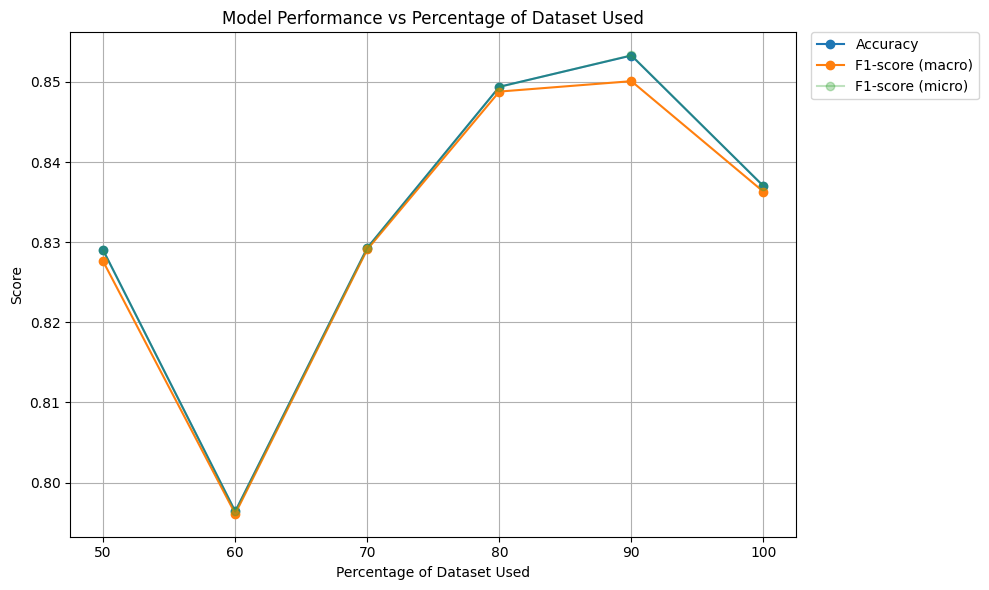

In [ ]:
import matplotlib.pyplot as plt
x = list(metrics.keys())
accuracy = [metrics[k][0] for k in x]
f1_macro = [metrics[k][1] for k in x]
f1_micro = [metrics[k][2] for k in x]

# رسم نمودار
plt.figure(figsize=(10, 6))
plt.plot(x, accuracy, marker='o', label='Accuracy')
plt.plot(x, f1_macro, marker='o', label='F1-score (macro)')
plt.plot(x, f1_micro, marker='o', label='F1-score (micro)', alpha=0.3)

# تنظیمات نمودار
plt.xlabel('Percentage of Dataset Used')
plt.ylabel('Score')
plt.title('Model Performance vs Percentage of Dataset Used')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(True)
#plt.xlim(45, 115)
plt.tight_layout()
plt.show()